In [ ]:
import pandas as pd
import regex as re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import pickle
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import io
from tensorflow.keras.layers import Embedding, RNN, Dense
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

In [ ]:
def main():
    """
    this function stores the correct sentence line by line in as txt file with file name lang8.train.auto.bea19.m2
    """
    
    m2 = open("lang8.train.auto.bea19.m2").read().strip().split("\n\n")
    out = open("lang8.train.auto.bea19.txt", "w")
    # Do not apply edits with these error types
    skip = {"noop", "UNK", "Um"}
    
    for sent in m2:
        sent = sent.split("\n")
        cor_sent = sent[0].split()[1:] # Ignore "S "
        edits = sent[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            if edit[1] in skip: continue # Ignore certain edits
            coder = int(edit[-1])
            if coder != 0: continue # Ignore other coders
            span = edit[0].split()[1:] # Ignore "A "
            start = int(span[0])
            end = int(span[1])
            cor = edit[2].split()
            cor_sent[start+offset:end+offset] = cor
            offset = offset-(end-start)+len(cor)
        out.write(" ".join(cor_sent)+"\n")
        
main()

#preprocessing incorrect sentences

file1 = open("lang8.train.auto.bea19.m2","r")
s1 = file1.read()

each_sent = s1.split("\n\n")

incorrect = []
for i in range(len(each_sent)):
    temp = each_sent[i].split("\n")
    temp = temp[0]
    temp = temp.split(" ")
    temp = temp[1:]# ignore S
    temp = ' '.join(temp)
    incorrect.append(temp)
    
#preprocessing correct sentences

file2 = open("lang8.train.auto.bea19.txt","r")
s2 = file2.read()

correct = s2.split("\n")

correct.pop(-1)

# storing correct and incorrect sentence pair into dataframe
df = pd.DataFrame()
df["correct"] = correct
df["incorrect"] = incorrect

#store into csv file named data.csv
df.to_csv("data.csv",index=False)

In [ ]:
index = []
for i in range(len(df.values)):
    if df.values[i][0] == df.values[i][1]:
        index.append(i)
            
df = df.drop(index)
df.shape

(134064, 2)

In [ ]:
df.isnull().values.any()

df.dropna(inplace=True)


# ckeck if any duplicate value is present
df.duplicated().values.any()

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)


In [ ]:
def clean(text):
    """
    takes string as input and
    removes characters inside (),{},[] and <>
    removes characters like -+@#^/|*(){}$~`
    we not not removing ,.!-:;"' as these characters are present in english language 
    """
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

In [ ]:
df.head()

,correct,incorrect
0,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .
1,"Actually , he was the one who let me know abou...","Actually , who let me know about Lang - 8 was ..."
2,His Kanji ability is much better than mine .,His Kanji 's ability is much better than me .
3,"We 've known each other for only half a year ,...","We 've known each other for only half a year ,..."
4,I heard a sentence last night when I was watch...,I heard a sentence last night when I watched TV .


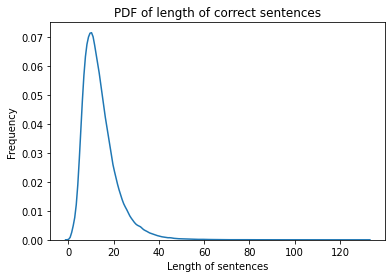

In [ ]:
corr_length = df["correct"].str.split().apply(len)
corr_length = list(corr_length)
sns.kdeplot(corr_length)
plt.xlabel("Length of sentences")
plt.ylabel("Frequency")
plt.title("PDF of length of correct sentences")
plt.show()

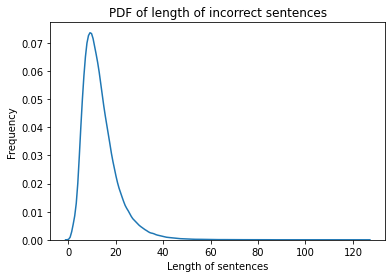

In [ ]:
incorr_length = df["incorrect"].str.split().apply(len)
incorr_length = list(incorr_length)
sns.kdeplot(incorr_length)
plt.xlabel("Length of sentences")
plt.ylabel("Frequency")
plt.title("PDF of length of incorrect sentences")
plt.show()

In [ ]:
def word_cloud(df,col):

    comment_words = '' 
    stopwords = set(STOPWORDS) 

# iterate through the csv file 
    for val in df[col]:
        val = str(val) 
    # split the value 
        tokens = val.split() 
    # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image
    plt.figure(figsize = (8,8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title("WORD CLOUD")
    plt.show()

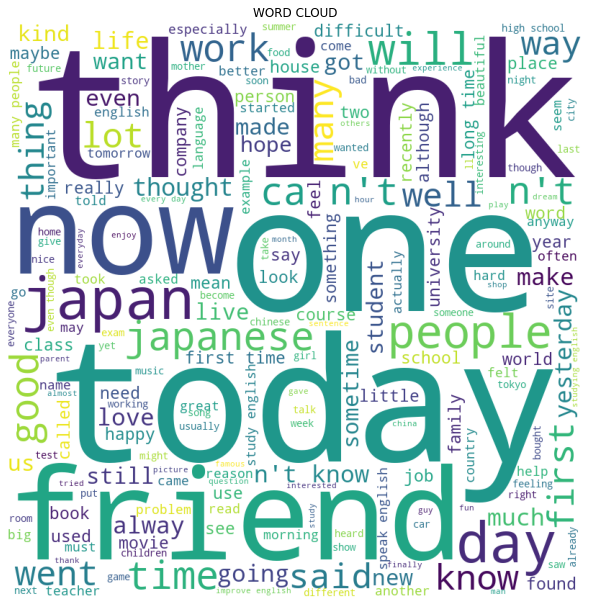

In [ ]:
word_cloud(df,"correct")

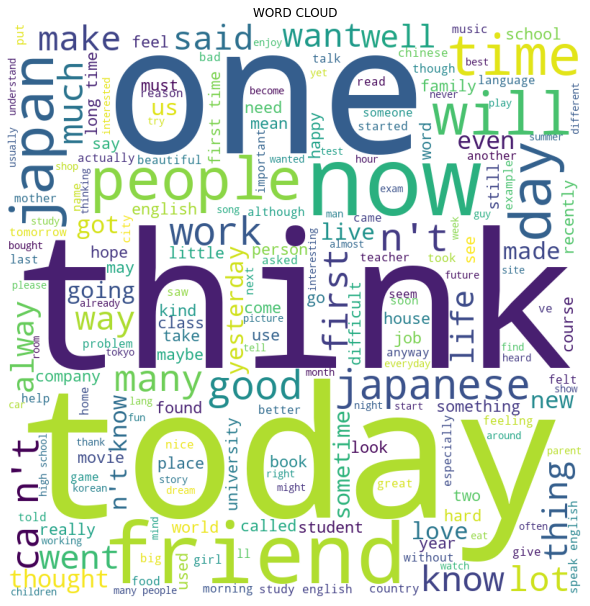

In [ ]:
word_cloud(df,"incorrect")

In [ ]:
train,test = train_test_split(df, random_state=0, train_size=0.8)
cv = train

In [ ]:
split_sent = np.array(train["incorrect"].str.split())

unique = []
for i in split_sent:
  if type(i) == float:
    continue
  for j in i:
    unique.append(j)

unique_words_train_incorr = set(unique)

print("Total number of unique words in incorrect sentences in train data are",len(unique_words_train_incorr))

Total number of unique words in incorrect sentences in train data are 42321


In [ ]:
split_sent = np.array(train["correct"].str.split())

unique = []
for i in split_sent:
  for j in i:
    unique.append(j)

unique_words_train_corr = set(unique)
print("Total number of unique words in correct sentences in train data are",len(unique_words_train_corr))

Total number of unique words in correct sentences in train data are 35120


In [ ]:
# for training data
train["correct_inp"] = "$" + train["correct"].astype(str)#$ denotes start of sentence
train["correct_out"] = train["correct"].astype(str) + "@"#@ denotes end of sentence

# for cv data
cv["correct_inp"] = "$" + cv["correct"].astype(str)
cv["correct_out"] = cv["correct"].astype(str) + "@"

In [ ]:
# tokenizing encoder input

tokenizer_incorr = Tokenizer(filters="",char_level=True,lower=False)
tokenizer_incorr.fit_on_texts(train["incorrect"].values)

incorr_train = np.array(tokenizer_incorr.texts_to_sequences(train["incorrect"].values))
incorr_cv = np.array(tokenizer_incorr.texts_to_sequences(cv["incorrect"].values))
print("vocab size of incorrrect sentences is",len(tokenizer_incorr.word_index))

# tokenizing decoder input

tokenizer_corr_inp = Tokenizer(filters="",char_level=True,lower=False)
tokenizer_corr_inp.fit_on_texts(train["correct_inp"].values)

corr_train_inp = np.array(tokenizer_corr_inp.texts_to_sequences(train["correct_inp"].values))
corr_cv_inp = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_inp"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_inp.word_index))

# tokenizing decoder output

tokenizer_corr_out = Tokenizer(filters="",char_level=True,lower=False)
tokenizer_corr_out.fit_on_texts(train["correct_out"].values)

corr_train_out = np.array(tokenizer_corr_out.texts_to_sequences(train["correct_out"].values))
corr_cv_out = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_out"].values))

## saving tokenizer

with open("tokenizer_incorr.pickle","wb") as temp1:
    pickle.dump(tokenizer_incorr,temp1)
    
with open("tokenizer_corr_inp.pickle","wb") as temp2:
    pickle.dump(tokenizer_corr_inp,temp2)
    
with open("tokenizer_corr_out.pickle","wb") as temp3:
    pickle.dump(tokenizer_corr_out,temp3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


vocab size of incorrrect sentences is 94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


vocab size of corrrect sentences is 94


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
# padding training data
# here we are keeping max length a 25, as we ecided from EDA
incorr_train = np.array(pad_sequences(incorr_train,maxlen=25,padding="post",truncating='post'))
corr_train_inp = np.array(pad_sequences(corr_train_inp,maxlen=25,padding="post",truncating='post'))
corr_train_out = np.array(pad_sequences(corr_train_out,maxlen=25,padding="post",truncating='post'))


# padding validation data
incorr_cv = np.array(pad_sequences(incorr_cv,maxlen=25,padding="post",truncating='post'))
corr_cv_inp = np.array(pad_sequences(corr_cv_inp,maxlen=25,padding="post",truncating='post'))
corr_cv_out = np.array(pad_sequences(corr_cv_out,maxlen=25,padding="post",truncating='post'))

In [ ]:
def load_vectors(fname):
    
    """
    this function takes name of file as input and returns a dictionary
    which contins word embedding of 300 dimension for each word
    """
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [ ]:
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        ## in init method we are initializing all the parameters that are to be used in call function
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence,states):
        
        ## pass input sequence to embedding layer
        output1 = self.embedding(input_sequence)
        ## pass output of embedding layer to encoder and initialize encoder with initial hidden and cell  states
        enco_output, enco_state_h, enco_state_c = self.encoder_lstm(output1, initial_state=states)
        ##return encoder hidden and cell state
        return enco_output, enco_state_h, enco_state_c

    
    def initialize_states(self,batch_size):

        ## initialize encoder with initial states with zero
        initial_hidden_state = tf.zeros([batch_size,self.lstm_size])
        initial_cell_state = tf.zeros([batch_size,self.lstm_size])
        
        return [initial_hidden_state,initial_cell_state]

In [ ]:
class Decoder(tf.keras.layers.Layer):

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)

    def call(self,target_sequence,initial_states):
        
        ## pass input sequence to embedding layer
        output2 = self.embedding(target_sequence)
         ## pass output of embedding layer to decoder and initialize decoder with last hidden and cell  states returned by encoder
        deco_output, deco_state_h, deco_state_c = self.decoder_lstm(output2, initial_state=initial_states)
      
        return deco_output, deco_state_h, deco_state_c

In [ ]:
final_state = 0
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,inp_vocab_size,out_vocab_size,embedding_size,lstm_size,input_length,batch_size,*args):
        
        super().__init__()
        ## initialize encoder object
        self.encoder = Encoder(inp_vocab_size,embedding_size,lstm_size,input_length)
        ## initialize decoder object
        self.decoder = Decoder(out_vocab_size,embedding_size,lstm_size,input_length)
        ## initialize dense laye
        self.dense   = Dense(out_vocab_size)
        self.batch = batch_size
    
    
    def call(self,data,*args):
        
        input,output = data[0], data[1]
        # initializing initial states of encoder
        l = self.encoder.initialize_states(self.batch)
        final_state = l
        ## pass input to encoder and output to decoder and get hidden and cell state for both
        encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input,l)
        m = list((encoder_final_state_h,encoder_final_state_c))
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.decoder(output,m)
        ## pass decode output to dense layer
        final_output = self.dense(decoder_output)
        return final_output

In [ ]:
## defining model parameters
inp_vocab_size = len(tokenizer_incorr.word_index) + 1
out_vocab_size = len(tokenizer_corr_out.word_index) + 1
embedding_dim=25
input_length=25
lstm_size=64
batch_size=256
model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)

## defining optimizer
optimizer = tf.keras.optimizers.Adam()

#defining custom loss function which will not consider loss for padded zeroes
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## compile the model
model.compile(optimizer=optimizer,loss=loss_function)

## using tensorflow callback
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## use model checkpointing o save the model
filepath="/content/drive/MyDrive/attention_model/weights-{epoch:02d}-{val_loss:.4f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss',  verbose=1, save_best_only=True, mode='auto',save_weights_only=True)

## train model
model.fit(x=[incorr_train,corr_train_inp],y=corr_train_out, epochs=1,batch_size=256,callbacks=[model_checkpoint,tensorboard_callback],validation_data=([incorr_cv,corr_cv_inp],corr_cv_out))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
418/419 [============================>.] - ETA: 0s - loss: 2.8189

InvalidArgumentError: ignored